### <font color="Red" size="6"> Juan Esteban Moreno Agudelo</font>
#***Homework # 9***

### *A typical regression problem can be written as:*

### $$\hat{y} = \beta_{0} + \beta_{1}\omega_{1} + , ..., \beta_{n}\omega_{n} \rightarrow \beta^{\top} [1;\, \omega] = \beta^{\top}x$$

### *We are going to minimize the next expression:*
### $$\beta^{*} = \text{argmin} | y_{i} - \hat{y}| = \sum_{i \in I}\big|y_{i} - \beta^{\top}x_{i}\big| $$

### *subject to:*

### $$r_{i} \geq y_{i} - \sum_{j \in F}\beta_{j}x_{ij} \quad \forall j \in F, \, \, \forall i \in I$$

### $$r_{i} \leq - y_{i} + \sum_{j \in F}\beta_{j}x_{ij} \quad \forall j \in F, \, \, \forall i \in I$$

### $F$ are the features of the problem and $I$ the amount of samples.


---

### *Let's structure the problem to apply consensus algorithm*

### $$\beta^{k+1}_{i}\, \colon = \,\underset{\beta_{i}}{\text{minimize}} \Big[ \sum_{i \in I}r_{i} + \sum_{j \in F}\lambda^{k}_{j}(\beta_{j} - \bar{z}^{k}) + \frac{\rho}{2} \| \beta_{j} - \bar{z}^{k}\|^{2}_{2} \Big] \quad \forall i \in P \quad (1)$$

### *Where $P$ are the groups of data, in this case 5 groups of 65 samples*
<br/>

### *Subject to:*
### $$r_{i} \geq y_{i} - \sum_{j \in F}\beta_{j}x_{ij} \quad \forall j \in F, \, \, \forall i \in P \quad \quad (2)$$

### $$r_{i} \leq - y_{i} + \sum_{j \in F}\beta_{j}x_{ij} \quad \forall j \in F, \, \, \forall i \in P \quad \quad (3)$$

### $$\lambda^{k+1}_{j}\, \colon=\, \lambda^{k}_{j} + \rho(\beta^{k+1}_{j} - \bar{z}^{k+1})\quad \quad (4)$$
---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyomo

     |████████████████████████████████| 9.5MB 23.7MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 256kB 46.2MB/s 
     |████████████████████████████████| 163kB 54.5MB/s 


In [3]:
# install ipopt
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

### <font color="Red" size="6"> Problema 1</font>
#***Proceso de imputación***

In [4]:
path = "/content/drive/My Drive/Colab Notebooks/HW9/"
filenames = "auto-mpg.names"
filedata = "auto-mpg.data"
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
from pyomo.opt import SolverStatus,TerminationCondition
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

solver = pyo.SolverFactory('ipopt', executable='/content/ipopt')

In [8]:
data = pd.read_table(os.path.join(path, filedata))
data.head()

names_cols = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"]

datContent = []
NUMERIC_COLS = 8
for i in open(os.path.join(path, filedata)).readlines():
    a = i.split()
    b = a[0:NUMERIC_COLS]
    b = b + [" ".join(a[NUMERIC_COLS:])]
    datContent.append(b)

data = {key : [] for key in names_cols}
for row in datContent:
    for name, col in enumerate(row):
        data[names_cols[name]].append(col)
        # cols_count += 1
dataRaw = pd.DataFrame(data)
print(f"dimensiones ---> rows {dataRaw.shape[0]} y columns {dataRaw.shape[1]}")

#Let's replace the ?
dataRaw = dataRaw.replace("?", np.nan)
dataRaw.head()

dimensiones ---> rows 378 y columns 9


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.,10.5,70,1,"""ford torino"""


In [14]:
# Let's change the type of column
def coerce_df_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')
    return df
numeric_cols = dataRaw.columns.values.tolist()[:8]
dataRaw = coerce_df_columns_to_numeric(dataRaw, numeric_cols)

# Let's check the Null data
nulls = pd.isnull(dataRaw["horsepower"]).values.ravel().sum()
print(f"Hay {nulls} datos nulos en la columna horsepower")

Hay 6 datos nulos en la columna horsepower


In [7]:
continuecols = dataRaw.columns.values.tolist()[0:6]
dataRaw[continuecols].corr()

corr = dataRaw[continuecols].corr()
corr.style.background_gradient(cmap='coolwarm')\
.set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
.set_caption("Correlation matrix")\
.set_precision(2)

,mpg,cylinders,displacement,horsepower,weight,acceleration
mpg,1.00,-0.78,-0.81,-0.78,-0.84,0.43
cylinders,-0.78,1.00,0.95,0.84,0.90,-0.52
displacement,-0.81,0.95,1.00,0.90,0.93,-0.56
horsepower,-0.78,0.84,0.90,1.00,0.86,-0.70
weight,-0.84,0.90,0.93,0.86,1.00,-0.43
acceleration,0.43,-0.52,-0.56,-0.70,-0.43,1.00


Text(0.5, 1.0, 'cylinders vs displacement')

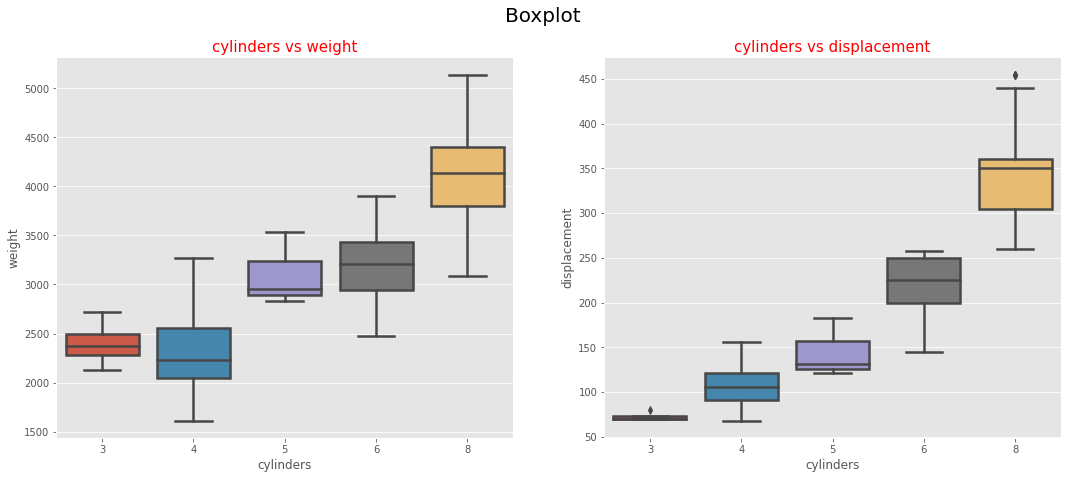

In [15]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(18,7))

fig.suptitle('Boxplot', color="black", fontsize=20)
sns.boxplot(ax=axs[0], x="cylinders", y="weight", data=dataRaw, linewidth=2.5)
axs[0].set_title("cylinders vs weight", color="red", fontsize=15)

sns.boxplot(ax=axs[1], x="cylinders", y="displacement", data=dataRaw, linewidth=2.5)
axs[1].set_title("cylinders vs displacement", color="red", fontsize=15)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


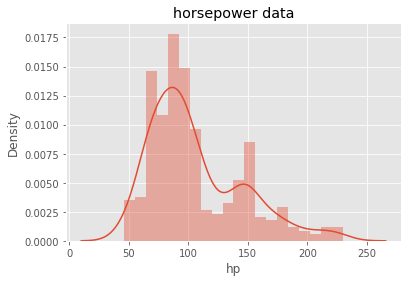

In [16]:
plt.figure(figsize=(6,4))
sns.distplot(dataRaw["horsepower"], kde=True, bins=20, hist=True)
plt.title("horsepower data")
plt.xlabel("hp")
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


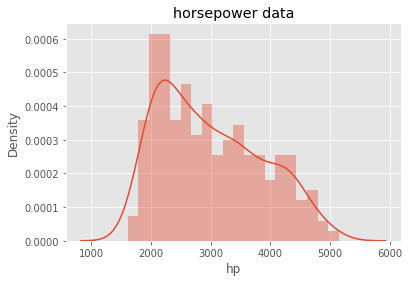

In [17]:
plt.figure(figsize=(6,4))
sns.distplot(data["weight"], kde=True, bins=20, hist=True)
plt.title("horsepower data")
plt.xlabel("hp")
plt.grid(True)
plt.show()

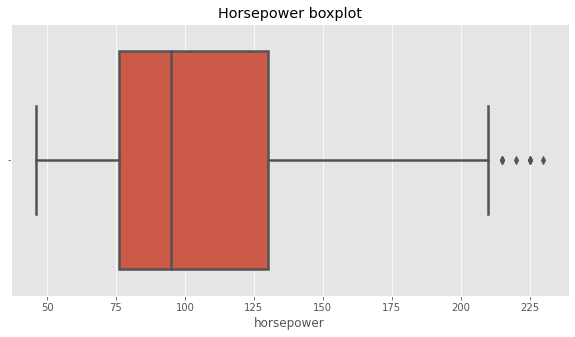

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Horsepower boxplot")
sns.boxplot(x="horsepower", data=dataRaw, linewidth=2.5)

In [19]:
#let's define 3 categories
bins = ["Low", "medium", "high"]

binsCyl = np.linspace(min(dataRaw["cylinders"]), max(dataRaw["cylinders"]), 4)
binsDispl = np.linspace(min(dataRaw["displacement"]), max(dataRaw["displacement"]), 4)
binsWeight = np.linspace(min(dataRaw["weight"]), max(dataRaw["weight"]), 4)

dataToImpute = dataRaw[["horsepower"]].copy()

In [20]:
dataToImpute['cylinders-bins'] = pd.cut(dataRaw['cylinders'], binsCyl, 
                                        labels=bins, include_lowest=True)
dataToImpute['displa-bins'] = pd.cut(dataRaw['displacement'], binsDispl, 
                                        labels=bins, include_lowest=True)
dataToImpute['weights-bins'] = pd.cut(dataRaw['weight'], binsWeight, 
                                        labels=bins, include_lowest=True)
dataToImpute.head()

,horsepower,cylinders-bins,displa-bins,weights-bins
0,130.0,high,medium,medium
1,165.0,high,high,medium
2,150.0,high,medium,medium
3,150.0,high,medium,medium
4,140.0,high,medium,medium


In [21]:
dataToImpute = dataToImpute.replace(np.nan, 0)
meanhp = pd.DataFrame(index=bins, columns=dataToImpute.columns[1:])

for column in meanhp.columns:
    for j in bins:
        suma=0; cont=0
        for k,i in enumerate(dataToImpute[column]):
            if j==i:
                suma+=dataToImpute['horsepower'].loc[k]
                cont+=1
        meanhp[column].loc[j]=int(suma/cont) 

In [22]:
meanhp

,cylinders-bins,displa-bins,weights-bins
Low,76,79,77
medium,99,116,109
high,158,171,166


In [23]:
dataRaw = dataRaw.copy()
for k,i in enumerate(dataToImpute['horsepower']):
  if i==0:
    suma=0; cont=0
    for j in meanhp.columns:
      ind = dataToImpute[j].loc[k]
      suma += meanhp[j].loc[ind]
      cont+=1 
    dataRaw['horsepower'].loc[k]=int(suma/cont)
    print(f'El automovil {k} será imputado con valor de {int(suma/cont)} para el Horsepower')

El automovil 32 será imputado con valor de 77 para el Horsepower
El automovil 126 será imputado con valor de 108 para el Horsepower
El automovil 330 será imputado con valor de 77 para el Horsepower
El automovil 336 será imputado con valor de 88 para el Horsepower
El automovil 354 será imputado con valor de 77 para el Horsepower
El automovil 374 será imputado con valor de 88 para el Horsepower


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# **Let's implement the model**

In [ ]:
# y = data["mpg"]
# X = data[data.columns.difference(['mpg', 'car name'])].copy()
# X["beta0"] = 1

# dummy_origin = pd.get_dummies(X["origin"], prefix="origin")
# dummy_cylinder = pd.get_dummies(X["cylinders"], prefix="cy")

# X = X.drop(["origin", "cylinders"], axis=1)
# Xupdate = pd.concat([X, dummy_origin, dummy_cylinder], axis=1)
# Xupdate["displacement^2"] = Xupdate["displacement"]**2
# Xupdate["horsepower^2"] = Xupdate["horsepower"]**2
# Xupdate["horsepower|displacement"] = Xupdate["horsepower"]*Xupdate["displacement"]

#shuffle
# Xupdate = Xupdate.sample(frac=1).reset_index(drop=True)
# fragments = [Xupdate.iloc[i:i+65] for i in range(0, 325, 65)]

# split the data in test and train
# X_train, X_test, y_train, y_test = train_test_split(Xupdate, y, test_size = 0.2, random_state=42)

In [24]:
model = pyo.AbstractModel()

# Sets
model.samples = pyo.Set(doc="Conjunto de muestras", ordered=False)
model.features = pyo.Set(doc="Conjunto de features", ordered=False)

# params
model.yTrain = pyo.Param(model.samples, domain=pyo.Reals, 
                         mutable=True, initialize=0)
model.x = pyo.Param(model.samples, model.features, initialize=0, mutable=True, 
                    domain=pyo.Reals, doc="coefficients accompanied beta")
model.z = pyo.Param(model.features, initialize=0, mutable=True, 
                    domain=pyo.Reals, doc="Consenso var")
model.Lambdas = pyo.Param(model.features, initialize=0, 
                          domain=pyo.Reals, mutable=True, doc="Multipliers")
model.rho = pyo.Param(initialize=0)

# vars
model.yHat = pyo.Var(model.samples, doc="milles per galon")
model.betaY = pyo.Var(model.features, doc="output var")
model.r = pyo.Var(model.samples)

In [25]:
def objective(model):
    return sum(model.r[i] for i in model.samples) + \
            sum(model.Lambdas[j]*(model.betaY[j] - \
                                  model.z[j]) for j in model.features) + \
           (model.rho/2)*(sum((model.betaY[j] - 
                               model.z[j])**2 for j in model.features))
model.loss = pyo.Objective(rule=objective, sense=pyo.minimize)

In [26]:
def constraint1(model, i):
    return model.yHat[i] == sum(model.betaY[j]*model.x[i, j] for j in model.features)
model.constrain1 = pyo.Constraint(model.samples, rule=constraint1)

def constraint2(model, i):  
    return model.r[i] >= model.yTrain[i] - model.yHat[i]
model.constraint2 = pyo.Constraint(model.samples, rule=constraint2)

def constraint3(model, i):  
    return model.r[i] >= - model.yTrain[i] + model.yHat[i]
model.constraint3 = pyo.Constraint(model.samples, rule=constraint3)

# def constraint4(model, j):
#     return (model.betaY[j] == model.z[j])
# model.consensous = pyo.Constraint(model.features, rule=constraint4)

In [ ]:
results = opt.solve(model)

Check status
if (results.solver.status == SolverStatus.ok) and \
        (results.solver.termination_condition == TerminationCondition.optimal):
    print("Optimal solution ")
    print(str(results.solver)) 
elif results.solver.termination_condition == TerminationCondition.infeasible:
    print("Something is wrong..")
else:
    # something is wrong
    print(str(results.solver)) 

### **Let's implement the consensus algorithm**

In [ ]:
#@title
eps = 1E-6 #Error GAP
zk = dict.fromkeys(first_instance.beta.keys(),0) #consensus parameter
beta_all = dict.fromkeys(train, {}) #Save all betas to compute Zk (mean of all betas)
Lambda_all = dict.fromkeys(train, {}) #Save all Lambdas for next iteration
flag = False 
counter=0
#initialize Lambda_all with 0.5
for k in Lambda_all.keys():
  Lambda_all[k] = dict.fromkeys(zk, 0.5)
  beta_all[k] = dict.fromkeys(zk, 0)
#=========Start iterations================
while flag == False:
  #Iterate over all six problems to find beta beta
  for keys, dataframe in train.items():
    #Separate X data and Y data
    datay = dataframe['mpg'] #take
    datax = dataframe[dataframe.columns[1:]]
    # Create data to input
    Ik = list(datax.index)
    J = list(datax.columns)
    x,y = {},{}
    for i in Ik:
      y[i] = datay[i]
      for j in J:
        x[i,j] = datax.loc[i,j]
    #With data ready, create datainstance
    data_ini = {
        None:{
            'Ik': Ik,
            'J': J,
            'x': x,
            'y': y,
            'z': zk,
            'Lambda': Lambda_all[keys]
            }
          }
    #create instance and solve
    iterationInstance = model.create_instance(data=data_ini)
    #Solve instance
    result = solver.solve(iterationInstance)

    #Once each problem is solved, save data in respective dict
    for k,v in iterationInstance.beta.items():
      beta_all[keys][k] = v.value
    #print(beta_all)
  #End of iteration of bloack Ik
  #Checking values:
  # for kk in beta_all.keys():
  #   # print(f'beta[k][beta0] = {beta_all[kk]["beta0"]}')
  #   print(kk)
  #Compute mean
  for k in zk.keys():
    zk[k] = sum(beta_all[i][k] for i in beta_all.keys())/len(beta_all)
  #Finish betai computation, now compute New Lambda (lagrange multiplier)
  # print(f'Zmean is: {zk["beta0"]}')
  
  for key in beta_all.keys():
    # print(f'Lambda {key} for this value was: {Lambda_all[key]}')
    for k,v in beta_all[key].items():
      Lambda_all[key][k] += 0.5*(beta_all[key][k] - zk[k])
  # #parada??
  if
  counter += 1
  if counter >= 20:
    flag = True

In [27]:
data = dataRaw
from collections import OrderedDict

In [28]:
data = data[data.columns.difference(['car name'])].copy()
data["beta0"] = 1

dummy_origin = pd.get_dummies(data["origin"], prefix="origin")
dummy_cylinder = pd.get_dummies(data["cylinders"], prefix="cy")
data = data.drop(["origin", "cylinders"], axis=1)

Xupdate = pd.concat([data, dummy_origin, dummy_cylinder], axis=1)
Xupdate["displacement"] = Xupdate["displacement"].astype(float)
Xupdate["displacement^2"] = Xupdate["displacement"]**2

Xupdate["horsepower"] = Xupdate["horsepower"].astype(float)
Xupdate["horsepower^2"] = Xupdate["horsepower"]**2
Xupdate["log(horsepower)"] = np.log(Xupdate["horsepower"])

#shuffle
Xupdate = Xupdate.sample(frac=1).reset_index(drop=True)
fragments = [Xupdate.iloc[i:i + 65].reset_index(drop=True) for i in range(0, 325, 65)]

# gap = 1000
values_k = {}
k = 0

beta_fragment = {}
lambdas_fragment = {}
tolerances = {}
status = True

while status == True:

    # dataframe to initialize data
    for i, dataframe in enumerate(fragments):

        y = dataframe["mpg"].to_dict()
        X = dataframe[dataframe.columns.difference(['mpg'])].copy()

        # Create the instances
        #sets
        samples = list(range(X.shape[0]))
        features = X.columns.values.tolist()

        #params
        dicX = {(s, f): X.loc[s, f] for s in X.index for f in X.columns}
        x = dicX
        rho = 30
        
        if k == 0: 
            z = {f:0 for f in features}
            Lambdas = {f:0 for f in features}
        else:
            z = zMeanD
            Lambdas = {feat: lambdas_fragment[k, i+1][c] for c, feat in enumerate(features)}
            

        # Let's add the instances 
        data_input = {None: dict(
                yTrain=y,
                samples=samples,
                features=features,
                x=x,
                z=z,
                Lambdas=Lambdas,
                rho={None: rho})}
        instancia = model.create_instance(data_input)
        solver.solve(instancia)
    
        #Get the betas    
        betas = instancia.betaY.get_values()
        betasArray = np.array([betas[feat] for feat in features])
        beta_fragment[(k+1, i+1)] = betasArray

        #Get the lagrangeanos
        zMean = np.array([z[feat] for feat in features])
        lambdasArray = np.array([Lambdas[feat] for feat in features])
        lambdas_fragment[(k+1, i+1)] = lambdasArray + rho*(betasArray - zMean)

        #Get tolerances
        tol = betasArray - zMean
        tolerances[(k+1, i+1)] = tol
    
    
    #Get the zMean or BetaMean
    betas = [beta_fragment[k+1, i] for i in range(1, 6)]
    zMean = np.mean(betas, axis=0)
    zMeanD = {feat: zMean[val] for val, feat in enumerate(features)}

    t = []
    tt = []
    for f in range(1, 6):
        value = np.mean(beta_fragment[k+1, f] - zMean)
        t.append(value)

        if abs(value) < 0.001:
            tt.append(value)
    
    if len(tt) == 5:
        status = False


    # tolerancia = [tolerances[k+1, i] for i in range(1, 6)]
    # toleranceOp = np.mean(tolerancia)
    
    # if abs(toleranceOp) < 0.0001:
    #     status = False
    # fo = instancia.loss.expr()
    
    print(f"Iteración: {k} fo -----> {tt}") 
    k += 1
    
    #break


Iteración: 0 fo -----> [0.00036890953356314533]
Iteración: 1 fo -----> []
Iteración: 2 fo -----> []
Iteración: 3 fo -----> [1.0239243294690632e-06]
Iteración: 4 fo -----> [0.0003217476663124293]
Iteración: 5 fo -----> [0.0006982365979954322, 0.0009698465434452952]
Iteración: 6 fo -----> [0.0007409311465674061, 0.00045937025103672907]
Iteración: 7 fo -----> [0.00040465445761928297, 0.00039405951071203456]
Iteración: 8 fo -----> [0.0005575844589742944, 0.000548450369512444]
Iteración: 9 fo -----> [0.000705435039063076, 0.0007042900684344656]
Iteración: 10 fo -----> [0.0006226322328343537, 0.0007097881959170415]
Iteración: 11 fo -----> [0.00055561053150483, 0.0006577229190919629]
Iteración: 12 fo -----> [0.000652649100118083, 0.0007417064454992597]
Iteración: 13 fo -----> [0.0008757086791963802, 0.000985021927829362]
Iteración: 14 fo -----> [0.0008536655966071189]
Iteración: 15 fo -----> [0.0008345051305468175]
Iteración: 16 fo -----> [0.000772258531432008]
Iteración: 17 fo -----> [0.0007

In [29]:
for i in range(5):
    print(beta_fragment[456, i+1])

[-1.15713872e-01  9.20908839e-03 -2.00000000e-02  2.19146757e-02
  6.66666666e-03 -4.36296442e-02  4.42573902e-02 -9.16727025e-02
  1.25150030e-04 -7.57767128e-02  3.27232279e-04  2.48034202e-02
  6.54728162e-01 -4.54558927e-02 -4.19962573e-02  9.66612385e-02
 -2.93347933e-03]
[-1.16058228e-01  9.18347610e-03 -2.00000000e-02  2.18641804e-02
  6.66666666e-03 -4.35821771e-02  4.42348061e-02 -9.24592140e-02
  1.72143352e-04 -7.68688900e-02  1.16983286e-04  2.47020158e-02
  6.52091829e-01 -4.54450412e-02 -4.20327212e-02  9.66612385e-02
 -2.89794830e-03]
[-1.15743703e-01  9.19974686e-03 -2.00000000e-02  2.18716407e-02
  6.66666666e-03 -4.35877145e-02  4.42491540e-02 -9.04404054e-02
  1.72790161e-04 -7.58494778e-02  1.79981279e-04  2.47714900e-02
  6.52703351e-01 -4.54221997e-02 -4.20325993e-02  9.66545458e-02
 -3.32781878e-03]
[-1.14943214e-01  9.30828410e-03 -2.00000000e-02  2.21041497e-02
  6.66666666e-03 -4.35877144e-02  4.41251822e-02 -9.39445915e-02
  1.49592094e-04 -7.28387994e-02  1.

In [182]:
#funcion objetivo
fo = instancia.loss.expr()
print('la funcion objetivo con pyomo es:',fo)

la funcion objetivo con pyomo es: 156.1765622935826


In [35]:
zMeanD

{'acceleration': -0.11610068308614033,
 'beta0': 0.00919630560860465,
 'cy_3': -0.01999999999676081,
 'cy_4': 0.0218868942628536,
 'cy_5': 0.006666666656501531,
 'cy_6': -0.04358043572949945,
 'cy_8': 0.04422318041550982,
 'displacement': -0.09242062193296488,
 'displacement^2': 0.00015769916433715667,
 'horsepower': -0.07637241541526084,
 'horsepower^2': 0.00020782612149118515,
 'log(horsepower)': 0.024751244554492666,
 'model year': 0.6531342575433317,
 'origin_1': -0.045534496652423276,
 'origin_2': -0.042018075391385204,
 'origin_3': 0.09674887765241344,
 'weight': -0.003010958526882711}

In [37]:
# import json

# with open(path + 'betas.json', 'w') as fp:
#     json.dump(zMeanD, fp)

In [40]:
test = Xupdate.loc[325:, ]
Xtest = test[test.columns.difference(["mpg"])]
Ytest = test["mpg"]

In [68]:
yresult = []
for row in range(325, 377+1):
    y = sum(Xtest.loc[row, :]*np.array([zMeanD[i] for i in features]))
    yresult.append(y)

In [69]:

def mean_absolute_percentage_error(Ytest, yresult): 
    Ytest, yresult = np.array(Ytest), np.array(yresult)
    return np.mean(np.abs((Ytest - yresult) / Ytest)) * 100

mape = mean_absolute_percentage_error(Ytest, yresult)
print(f"EL mape del modelo obtenido es {mape:.3f} %")

EL mape del modelo obtenido es 10.849 %


In [65]:
Ytest, yresult = np.array(Ytest), np.array(yresult)

print("Este es Ytest\n",Ytest)
print("\nEste es Ypredict\n", yresult)

Este es Ytest
 [12.  26.  28.  25.1 29.  15.  19.2 33.  26.6 16.2 18.  29.  25.  37.2
 23.  26.  21.5 18.  18.1 20.2 23.  26.  23.  15.  14.  13.  21.  31.5
 24.  13.  14.  32.  18.  17.5 15.  29.9 23.2 26.  13.  18.5 23.7 22.
 46.6 43.4 27.  18.  18.  22.3 18.  34.5 12.  28.1 20.6]

Este es Ypredict
 [12.24667018 25.42259618 29.44031391 26.10373222 30.89103454 12.9175362
 19.39562327 31.87115862 20.848327   21.53140548 17.03401294 28.78544459
 24.57359886 33.63074539 26.59929906 29.5532615  26.32187337 13.97785873
 19.99545123 21.54154132 23.76551145 26.88213956 24.27686439 14.72384717
 12.49271585 12.11079912 24.00750082 30.44332071 28.00882496 15.33779734
 13.38558306 30.74380991 14.00617941 18.68990939 14.90797391 31.7945596
 24.53357875 28.89876617 14.46042113 17.68362545 32.45719335 18.91749407
 33.18259714 32.32591112 30.06067585 21.70488693 16.68943511 26.02441223
 16.90824981 31.86709454 15.57006828 26.23175396 20.30631497]
